In [1]:
from __init__ import *

# Load expansion coefficients $c_{\mathrm{GT}}$

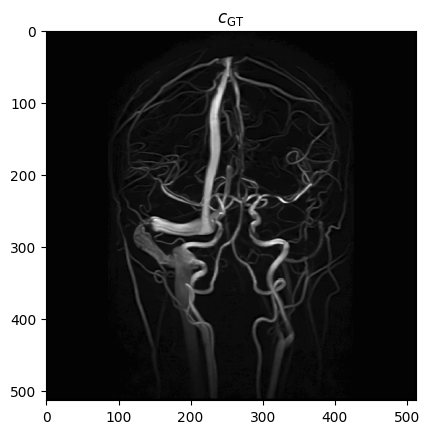

In [2]:
device = 'cpu'

c_gt = torch.load('ExpA/data/c_gt.pt').to(device)

# to impose boundary conditions and between 0 and 1
c_gt = F.pad(c_gt[:, :, 2:-2, 2:-2], (2, 2, 2, 2))
c_gt = (c_gt- c_gt.min()) / (c_gt.max() - c_gt.min())

plt.imshow(c_gt[0, 0], cmap='gray')
plt.title('$c_{\mathrm{GT}}$')
plt.show()

# Generate Evaluation Grid $4096 \times 4096$

In [3]:
N_grid = 4096 
h = 512 / (N_grid - 1)
start = 0
end = 512 - h
grid_eval = create_grid_coords(start, end, N_grid) + (h/2)

torch.save(grid_eval, 'ExpA/data/grid_eval.pt')

# Perfect reconstruction measurements and GT 

In [4]:
gt_PR = BoxGrid(513, 0, 512, c_init=c_gt.to(device), device=device)
gt_PR_eval = gt_PR.evaluate(grid_eval).view(1, 1, N_grid, N_grid)

mask_PR = torch.ones(1, 1, 512, 512)

mri_PR = MRICPWL(mask_PR, device)
mri_PR.set_h(1)

y_PR = mri_PR.H(c_gt[:, :, :-1, :-1])

torch.save(gt_PR_eval, 'ExpA/data/gt_PR.pt')
torch.save(mask_PR, 'ExpA/data/mask_PR.pt')
torch.save(y_PR, 'ExpA/data/y_PR.pt')

# Compressed-sensing setup measurements and GT 

In [5]:
def cubicbspline(x):
    out1 = (x+2)**3 * ((-2<= x) * 1 * (x <=-1)) 
    out2 = (-3*(x+1)**3 + 3*(x+1)**2 + 3*(x+1)**1 + 1) * ((-1< x) * 1 * (x <0)) 
    out3 = (-3*(1-x)**3 + 3*(1-x)**2 + 3*(1-x)**1 + 1) * ((0<= x) * 1 * (x <1)) 
    out4 = (2- x)**3 * ((1<= x) * 1 * (x <=2)) 
    return (out1 + out2 + out3 + out4) / 6

s = 5;  N = 2** (s+1) + 1
act = np.linspace(-2, 2, N)
kernel_intp = cubicbspline(act)
kernel_intp = torch.from_numpy(np.outer(kernel_intp, kernel_intp)).double().to(device).view(1, 1, N, N)

gt_CS_eval = F.conv_transpose2d(c_gt, kernel_intp, padding=(N//2), stride=2**(s-1))[:, :, 1::2, 1::2]  # relation between bicubic exp coef and sampled values on fine grids

mat = scipy.io.loadmat('ExpA/data/radial_mask.mat')
mask_CS = torch.from_numpy(mat['mask']).double().to(device).view([1, 1, 256, 256])

mri_CS = MRICubic(mask_CS, device)
mri_CS.set_h(0.5)
y_CS = mri_CS.H(c_gt[:, :, :-1, :-1])


torch.save(gt_CS_eval, 'ExpA/data/gt_CS.pt')
torch.save(mask_CS, 'ExpA/data/mask_CS.pt')
torch.save(y_CS, 'ExpA/data/y_CS.pt')

In [6]:
# to interpolate values using scipy, gives the same result as proposed but much slower

'''gx = torch.linspace(0, 8, 9)
kernel_intp = np.array([1/6, 2/3, 1/6])
kernel_intp = torch.from_numpy(np.outer(kernel_intp, kernel_intp)).double().to(device).view(1, 1, 3, 3)

interp_bicubic = RegularGridInterpolator((torch.linspace(0, 512, 513), torch.linspace(0, 512, 513)), sampled_gt[0, 0].numpy(), method='cubic')

gt_CS_eval = interp_bicubic(grid_eval).reshape(N_grid, N_grid) # takes time
gt_CS_eval = torch.clip(torch.tensor(gt_CS_eval).view(1, 1, 4096, 4096), 0, 1)'''

"gx = torch.linspace(0, 8, 9)\nkernel_intp = np.array([1/6, 2/3, 1/6])\nkernel_intp = torch.from_numpy(np.outer(kernel_intp, kernel_intp)).double().to(device).view(1, 1, 3, 3)\n\ninterp_bicubic = RegularGridInterpolator((torch.linspace(0, 512, 513), torch.linspace(0, 512, 513)), sampled_gt[0, 0].numpy(), method='cubic')\n\ngt_CS_eval = interp_bicubic(grid_eval).reshape(N_grid, N_grid) # takes time\ngt_CS_eval = torch.clip(torch.tensor(gt_CS_eval).view(1, 1, 4096, 4096), 0, 1)"